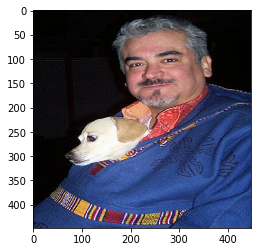

In [1]:
import sys
from tqdm import tqdm_notebook as tqdm
sys.path.append('./')

from yolo.net.yolo_tiny_net import YoloTinyNet 
import tensorflow as tf 
import cv2
import numpy as np
common_params = {
    'image_size': 448,
    'batch_size': 16,
    'num_classes': 20,
    'max_objects_per_image': 20
}
net_params = {'cell_size': 7, 'boxes_per_cell':2, 'weight_decay': 0.0005}

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
img_dir = '/media/labhdd/VOCdevkit/VOC2007/JPEGImages/'
def load_voc_test_img(img_name):
    img_path = img_dir+img_name
    np_img = cv2.imread(img_path)
    if len(np_img) ==0:
        raise Exception('img not found')
    return np_img
np_img = load_voc_test_img('000001.jpg')
resized_img = cv2.resize(np_img, (common_params['image_size'], common_params['image_size']))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
plt.imshow(np_img)
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, 448, 448, 3))



In [2]:
test_img_files = open('pascal_voc_testing_data.txt')
test_images = []
for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])
print(test_images[:3])

['000001.jpg', '000002.jpg', '000003.jpg']


In [3]:

classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]

n_box = 5
def process_predicts(predicts):
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (7, 7, 1, 20))
    C = np.reshape(C, (7, 7, 2, 1))

    P = C * p_classes

    #print P[5,1, 0, :]
    # index = np.argmax(P)
    xmin =[]
    ymin = []

    xmax = []
    ymax = []
    class_num = []
    conf = []
    Psort = np.argsort(P.flatten())
    for i in range(n_box):
        index = Psort[-(i+1)]
        tmp_conf = P.flatten()[index]
        if tmp_conf < 0.17 and (i != 0):
            break
        index = np.unravel_index(index, P.shape)

        class_num.append(index[3])

        coordinate = np.reshape(coordinate, (7, 7, 2, 4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (448/7.0)
        ycenter = (index[0] + ycenter) * (448/7.0)

        w = w * 448
        h = h * 448
        xmin_tmp = xcenter - w/2.0
        ymin_tmp = ycenter - h/2.0
        xmin.append(xmin_tmp)
        ymin.append(ymin_tmp)

        xmax.append(xmin_tmp + w)
        ymax.append(ymin_tmp + h)
        conf.append(tmp_conf)
    return xmin, ymin, xmax, ymax, class_num,conf


In [ ]:


tf.reset_default_graph()

net = YoloTinyNet(common_params, net_params, test=True)
# net = YoloNet(common_params, net_params, test=True)


In [9]:

image = tf.placeholder(tf.float32, (1, 448, 448, 3))
predicts = net.inference(image)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5

sess = tf.Session(config=config)
#load model
saver = tf.train.Saver(net.trainable_collection)
saver.restore(sess, './models/train/model.ckpt-1000')
output_file = open('./yolo_tiny_predion.txt', 'w')
with output_file as f:
#     for i in tqdm(range(len(test_images))):
    for i in range(100):
        np_img = load_voc_test_img(test_images[i])
        #preprocess
        h,w = np_img.shape[:2]
        resized_img = cv2.resize(np_img, (448, 448))
        np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        np_img = np_img.astype(np.float32)
        np_img = np_img / 255.0 * 2 - 1
        np_img = np.reshape(np_img, (1, 448, 448, 3))


        np_predict = sess.run(predicts, feed_dict={image: np_img})

        xmin, ymin, xmax, ymax, class_num,conf = process_predicts(np_predict)
        xmin = np.clip(xmin, 0,w-1)
        ymin = np.clip(ymin, 0,h-1)
        xmax = np.clip(xmax, 0,w-1)
        ymax = np.clip(ymax, 0,h-1)
        
        f.write(test_images[i])
        for j in range(len(xmin)):
            f.write(" %d %d %d %d %d %.2f" %(xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))
        f.write("\n")
    sess.close()
print('file output to ./yolo_tiny_predion.txt')

INFO:tensorflow:Restoring parameters from ./models/train/model.ckpt-1000
file output to ./yolo_tiny_predion.txt


In [35]:
np_img = load_voc_test_img(test_images[0])
h,w = np_img.shape[:2]
print(h)

500


In [17]:
with open('./test_out.txt', 'w') as f:
    f.write('foo.jpg')
    f.write(" %d %d %d %d %d %.2f" %(1,1,1,1,1,1.123))
    f.write(" %d %d %d %d %d %f" %(2,1,1,1,1,1.))
    f.write("\n")